Introduction:

Birdwatching, and associated activities such as identifying birds, has been a common hobby for centuries. In just February of this year, the world record for most birds having been seen across the world, 10 000 birds, was broken. A new bird species, the Cinnyris infrenatus, was found as recently as 2022 and there will never be a guarantee that humans have identified all bird species. If non-experts come across a bird which happens to be an unknown species, the only form of evidence they might be able to collect may be a picture. From these pictures we would likely be able to identify dimensions such as the bird's wingspan, beak size and more. 
Thus, our question is:
Based on an unknown bird's dimentions, what family does the given bird belong to?

We will be using the AVONET database, compiled by Tobias et al. (2022). It is compiled in an excel sheet. We will primarily be focusing on page 2 of the excel sheet "AVONET1_BirdLife". This dataset describes more than 90 000 individual birds form over 11 000 species. The individuals are grouped into species and each observation includes the order and family of each species of bird as well as the average beak length, width and depth, wingspan, tarsus length, kipps distance, tail length and mass among all recorded individuals of the species. There is also location information in the form of the average coordinates at which the birds were found as well as the habitat in which they inhabited. 

Tobias, J. A., Sheard, C., Pigot, A. L., Devenish, A. J., Yang, J., Sayol, F., Neate‐Clegg, M. H., Alioravainen, N., Weeks, T. L., Barber, R. A., Walkden, P. A., MacGregor, H. E., Jones, S. E., Vincent, C., Phillips, A. G., Marples, N. M., Montaño‐Centellas, F. A., Leandro‐Silva, V., Claramunt, S., … Schleuning, M. (2022). Avonet: Morphological, ecological and geographical data for all birds. Ecology Letters, 25(3), 571–707. https://doi.org/10.1111/ele.13898 

In [23]:
library(repr)
library(tidyverse)
library(tidymodels)
library(readxl)
library(httr)

set.seed(1)
options(repr.plot.height = 9, repr.plot.width = 14)

In [17]:
packageVersion("readxl")
# [1] ‘0.1.1’
url = "https://github.com/danizenarosa/dsci-100-grp43/raw/main/data/birds.xlsx"
GET(url, write_disk(tf <- tempfile(fileext = ".xlsx")))
birds_data <- read_excel(tf, 2, col_types = "text") |>
              mutate(Total.individuals = as.numeric(Total.individuals), across(Beak.Length_Culmen:Mass, as.numeric))

birds_count <- select(birds_data, Family1, Total.individuals, Beak.Length_Culmen:Mass) |>
    group_by(Family1) |>
    summarize(count = sum(Total.individuals), across(Beak.Length_Culmen:Mass, mean)) |> 
    slice_max(count, n = 10)   
birds_count

[1] ‘1.4.3’

Response [https://raw.githubusercontent.com/danizenarosa/dsci-100-grp43/main/data/birds.xlsx]
  Date: 2024-03-10 06:57
  Status: 200
  Content-Type: application/octet-stream
  Size: 21.5 MB
<ON DISK>  /tmp/RtmpbOGeAH/filec53be66f5e.xlsxNULL

Family1,count,Beak.Length_Culmen,Beak.Length_Nares,Beak.Width,Beak.Depth,Tarsus.Length,Wing.Length,Kipps.Distance,Secondary1,Hand-Wing.Index,Tail.Length,Mass
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Thraupidae,4988,14.98162,9.151471,5.147059,6.517402,20.008088,73.55637,13.916176,59.51912,18.84118,59.21642,23.264240
Tyrannidae,4670,15.56258,9.114031,5.036748,4.019154,18.646771,71.56526,14.118040,57.40601,18.39532,61.27528,17.638731
Furnariidae,3878,22.19301,15.050760,3.935866,4.908511,22.293313,80.44681,13.644681,66.80365,16.38172,79.69544,30.622097
Trochilidae,3232,23.85738,18.869672,2.165574,2.053279,5.131148,57.00355,35.921038,20.89918,63.43224,40.48607,5.136995
Muscicapidae,2927,16.52776,9.501493,4.050448,4.124478,23.618209,81.11552,15.688657,65.33761,19.14179,64.11015,24.417015
Thamnophilidae,2868,18.38388,10.777273,4.492149,4.857851,22.309917,63.35909,6.833884,57.16033,10.83967,52.60868,20.520620
Psittacidae,2212,25.13895,20.775263,12.623421,21.402632,16.787895,152.61053,60.650789,91.83684,40.39026,114.55868,166.488474
Columbidae,2197,22.42493,11.301133,4.667422,5.226912,27.532295,169.17167,53.297167,115.84533,31.12011,112.45552,257.899122
Pycnonotidae,2003,19.73671,11.323418,4.498101,5.304430,19.901266,91.59810,14.243038,77.30633,15.30506,85.13608,35.827025


It can be seen that the averages of the dimensions of the top 10 most populous bird families differ enough to be used as identification.

[1] "Thraupidae"     "Tyrannidae"     "Furnariidae"    "Trochilidae"   
 [5] "Muscicapidae"   "Thamnophilidae" "Psittacidae"    "Columbidae"    
 [9] "Pycnonotidae"   "Parulidae"

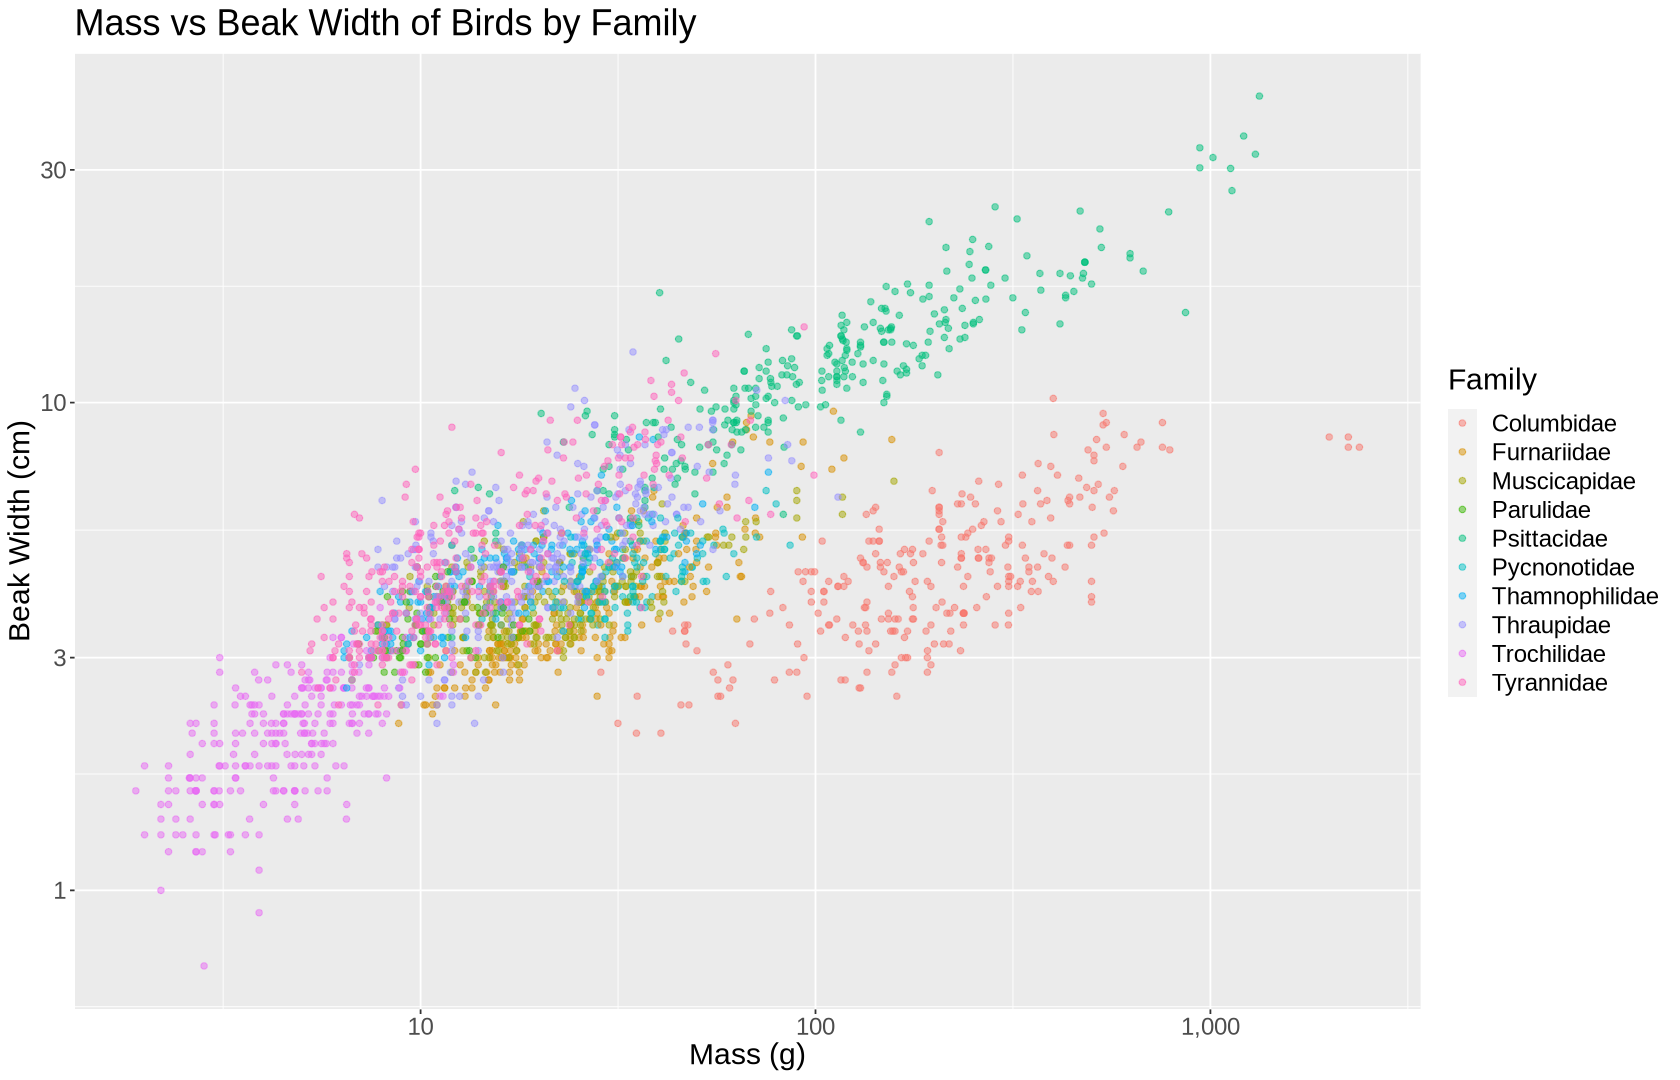

In [26]:
birds_top_10 <- birds_count |>
                pull(Family1)
birds_top_10

birds_data_pruned <- filter(birds_data, Family1 %in% birds_top_10)

split_birds <- initial_split(birds_data_pruned, prop = 0.75, strata = Family1)
training_birds <- training(split_birds)
test_birds <- testing(split_birds)

bird_beak_mass_plot <- training_birds |>
    ggplot(aes(x = Mass, y = Beak.Width, color = Family1)) +
    geom_point(alpha = .5) +
    labs(x = "Mass (g)", y = "Beak Width (cm)", color= "Family", title = "Mass vs Beak Width of Birds by Family") +
    scale_x_log10(labels = label_comma()) +
    scale_y_log10(labels = label_comma()) +
    theme(text = element_text(size = 18))

bird_beak_mass_plot

Using the mass and beak width of the 10 most populous birds in our dataset, there is evidence of distinct groups, such as Trochilidae (Parrots), Columbidae (Doves and  Pigeons), and Trochilidae (Hummingbirds). The center of the graph is noisy, but by using other variables we strive to distinguish each bird family by a large margin in order to to build a predictive model. 

Methods:

In this investigation, we will be using the columns; beak length, beak width, beak depth, tarsus length, wing length, kipps distance, hand-wing index, tail length and mass as the dimensions of the bird to classify the family that the invdividual belongs in. We will perform cross-validation to evaluate the performance of the model and to identify the k nearest neighbors value that best reflects the whole dataset. One way that we will visualize the results is through a set of plots that contain specific characterstics and their resulting families, for example, beak length vs family.

Expected outcomes and significance:

We expect to find a strong correlation between bird dimensions and their family, even across different species. Should the dimensions themselves not have strong correlation with their families, we expect the ratios of these dimensions should also show a strong relationship between species of the same family. From this we will be able to predict the family of unknown birds based only on their dimensions. 

If non-experts come across new bird species, it could be vital to be able to identify the bird's close biological relatives (i.e the bird's family on the tree of life) for scientists to identify important biological traits without being present to study them. As mentioned above, it is likely evidence might only be able to exist in the form of an image and so more specific behavioural data may not be able to be taken. 

If our hypothesis is proven, then it could lead to questions about how or why certain species, despite living on opposite sides of the world, develop similar features.